In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchviz
!pip install torchview
!pip install torchsummary
!pip install pytorch-lightning
!pip install lightning-bolts

  Preparing metadata (setup.py) ... - done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4131 sha256=196116230cb7ff74722eae5f5737440db4c943304e099523f0c5a953f7a85512
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.8/300.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 33.9 MB/s eta 0:00:00
  Attempting uninstall: pytorch-lightning
    Found existing installation: pytorch-lightning 2.2.1
    Uninstalling pytorch-lightning-2.2.1:
      Successfully uninstalled pytorch-lightning-2.2.1


In [3]:


import torch
import torchvision.models as models
import numpy as np
import os
import torch
import torchvision.transforms as T
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.multiprocessing import cpu_count
import torchvision.transforms as T

def default(val, def_val):
    return def_val if val is None else val

def reproducibility(config):
    SEED = int(config.seed)
    torch.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    if (config.cuda):
        torch.cuda.manual_seed(SEED)

def device_as(t1, t2):
    """
    Moves t1 to the device of t2
    """
    return t1.to(t2.device)

# From https://github.com/PyTorchLightning/pytorch-lightning/issues/924
def weights_update(model, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in checkpoint['state_dict'].items() if k in model_dict}
    model_dict.update(pretrained_dict)
    model.load_state_dict(model_dict)
    print(f'Checkpoint {checkpoint_path} was loaded')
    return model

In [4]:
X_train = np.load('/kaggle/input/pretrained-unlabelled/X_pretrain.npy')

In [5]:


import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

class Augment:
    def __init__(self, img_size, s=1):
        self.train_transform = A.Compose([
            A.RandomResizedCrop(img_size, img_size),
            A.HorizontalFlip(p=0.5),
#             A.ColorJitter(brightness=0.8*s, contrast=0.8*s, saturation=0.8*s, hue=0.2*s),
            A.GaussianBlur(blur_limit=(3, 7)),  # Adjusted to ensure odd blur limits
            ToTensorV2(),
        ])

        self.test_transform = A.Compose([
            A.Resize(img_size, img_size),
            ToTensorV2(),
        ])

    def __call__(self, x, train=True):
        if train:
            return self.train_transform(image=x)['image'], self.train_transform(image=x)['image']
        else:
            return self.test_transform(image=x)['image'], self.test_transform(image=x)['image']


import matplotlib.pyplot as plt

def imshow(img):
    """
    shows an imagenet-normalized image on the screen
    """
    mean = torch.tensor([0.485, 0.456, 0.406], dtype=torch.float32)
    std = torch.tensor([0.229, 0.224, 0.225], dtype=torch.float32)
    unnormalize = T.Normalize((-mean / std).tolist(), (1.0 / std).tolist())
    npimg = unnormalize(img).numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [6]:



class ContrastiveLoss(nn.Module):
    """
    Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
    """
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float()

    def calc_similarity_batch(self, a, b):
        representations = torch.cat([a, b], dim=0)
        return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    def forward(self, proj_1, proj_2):
        """
        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        batch_size = proj_1.shape[0]
        z_i = F.normalize(proj_1, p=2, dim=1)
        z_j = F.normalize(proj_2, p=2, dim=1)

        similarity_matrix = self.calc_similarity_batch(z_i, z_j)

        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)

        nominator = torch.exp(positives / self.temperature)

        denominator = device_as(self.mask, similarity_matrix) * torch.exp(similarity_matrix / self.temperature)

        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(all_losses) / (2 * self.batch_size)
        return loss

## Add projection Head for embedding and training logic with pytorch lightning model


In [7]:

import pytorch_lightning as pl
import torch
import torch.nn.functional as F
from pl_bolts.optimizers.lr_scheduler import LinearWarmupCosineAnnealingLR
from torch.optim import SGD, Adam


class AddProjection(nn.Module):
    def __init__(self, config, model=None, mlp_dim=512):
        super(AddProjection, self).__init__()
        embedding_size = config.embedding_size
        self.backbone = default(model, models.resnet18(pretrained=False, num_classes=config.embedding_size))
#         mlp_dim = default(mlp_dim, self.backbone.fc.in_features)
        print('Dim MLP input:',mlp_dim)
        self.backbone.fc = nn.Identity()

        # add mlp projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features=mlp_dim, out_features=mlp_dim),
            nn.BatchNorm1d(mlp_dim),
            nn.ReLU(),
            nn.Linear(in_features=mlp_dim, out_features=embedding_size),
            nn.BatchNorm1d(embedding_size),
        )

    def forward(self, x, return_embedding=False):
        embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.projection(embedding)

def define_param_groups(model, weight_decay, optimizer_name):
    def exclude_from_wd_and_adaptation(name):
        if 'bn' in name:
            return True
        if optimizer_name == 'lars' and 'bias' in name:
            return True

    param_groups = [
        {
            'params': [p for name, p in model.named_parameters() if not exclude_from_wd_and_adaptation(name)],
            'weight_decay': weight_decay,
            'layer_adaptation': True,
        },
        {
            'params': [p for name, p in model.named_parameters() if exclude_from_wd_and_adaptation(name)],
            'weight_decay': 0.,
            'layer_adaptation': False,
        },
    ]
    return param_groups


/opt/conda/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/opt/conda/lib/python3.10/site-packages/pl_bolts/__init__.py:11: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, tp_name):
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:34: UnderReviewWarning: The feature generate_power_seq is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  "lr_options": generate_power_seq(LEARNING_RATE_CIFAR, 11),
/opt/conda/lib/python3.10/site-packages/pl_bolts/models/self_supervised/amdim/amdim_module.py:92: UnderReviewWarning: The featu

In [8]:

class SimCLR_pl(pl.LightningModule):
    def __init__(self, config, model=None, feat_dim=512):
        super().__init__()
        self.config = config
        
        self.model = AddProjection(config, model=model, mlp_dim=feat_dim)

        self.loss = ContrastiveLoss(config.batch_size, temperature=self.config.temperature)
        self.validation_step_outputs = []
        self.train_step_outputs = []
        self.train_losses = []
        self.val_losses = []
        
    def forward(self, X):
        return self.model(X)

    def training_step(self, batch, batch_idx):
        (x1, x2) = batch
        z1 = self.model(x1)
        z2 = self.model(x2)
        loss = self.loss(z1, z2)
        self.log('Contrastive loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.train_step_outputs.append(loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        (x1, x2) = batch
        z1 = self.model(x1)
        z2 = self.model(x2)
        loss = self.loss(z1, z2)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.validation_step_outputs.append(loss)
        return loss

    def on_validation_epoch_end(self):
        avg_train_loss = torch.tensor(self.train_step_outputs).mean()
        avg_val_loss = torch.tensor(self.validation_step_outputs).mean()
        self.train_losses.append(avg_train_loss)
        self.val_losses.append(avg_val_loss)
        self.train_step_outputs = []
        self.validation_step_outputs = []
        print(f'Epoch {self.current_epoch}: Average Training Loss: {avg_train_loss:.4f}, Average Validation Loss: {avg_val_loss:.4f}')

    def configure_optimizers(self):
        max_epochs = int(self.config.epochs)
        param_groups = define_param_groups(self.model, self.config.weight_decay, 'adam')
        lr = self.config.lr
        optimizer = Adam(param_groups, lr=lr, weight_decay=self.config.weight_decay)

        print(f'Optimizer Adam, '
              f'Learning Rate {lr}, '
              f'Effective batch size {self.config.batch_size * self.config.gradient_accumulation_steps}')

        scheduler_warmup = LinearWarmupCosineAnnealingLR(optimizer, warmup_epochs=10, max_epochs=max_epochs,
                                                         warmup_start_lr=0.0)

        return [optimizer], [scheduler_warmup]

## Hyperparameters, and configuration stuff




In [9]:
# a lazy way to pass the config file
class Hparams:
    def __init__(self):
        self.epochs = 30 # number of training epochs
        self.seed = 77777 # randomness seed
        self.cuda = True # use nvidia gpu
        self.img_size = 125 #image shape
        self.save = "./saved_models/" # save checkpoint
        self.load = False # load pretrained checkpoint
        self.gradient_accumulation_steps = 5 # gradient accumulation steps
        self.batch_size = 200
        self.lr = 3e-4 # for ADAm only
        self.weight_decay = 1e-6
        self.embedding_size= 128 # papers value is 128
        self.temperature = 0.5 # 0.1 or 0.5
        self.checkpoint_path = './SimCLR_ResNet18.ckpt' # replace checkpoint path here



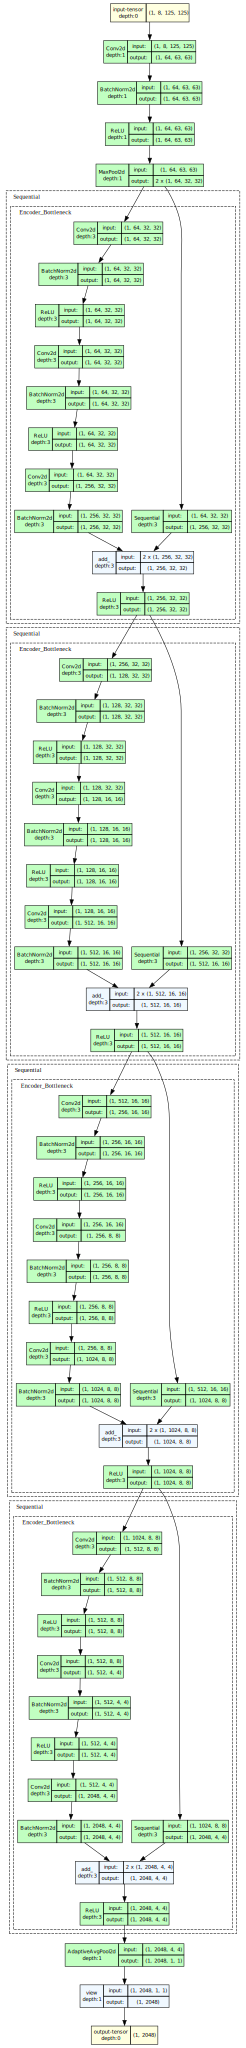

In [10]:
from functools import partial
from typing import Any, Callable, List, Optional, Type, Union

import torch
import torch.nn as nn
from torch import Tensor

from torchsummary import summary

'''
Modified from https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py
'''

def enc_conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def enc_conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class Encoder_Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = enc_conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = enc_conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = enc_conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Encoder(nn.Module):
    def __init__(
        self,
        block,
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        return_indices = False,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(8, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.return_indices = return_indices
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, return_indices=True)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block,
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                enc_conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x, _ = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        return x


    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

# if __name__ == "__main__":
    # image size: [64, 3, 224, 224]
    # feature size: [64, 2048]
encoder = Encoder(Encoder_Bottleneck, [1, 1, 1, 1], return_indices=True)
# resnet101 = ResNet(Bottleneck, [3, 4, 23, 3])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)

# summary(resnet50, (3, 224, 224))
import torchvision
from torchview import draw_graph
from torchviz import make_dot

model_graph = draw_graph(encoder, input_size=(1,8,125,125), expand_nested=True)
model_graph.visual_graph
    
    # test_input = torch.rand(2, 3, 224, 224).to(device)
    # out, indices = resnet50(test_input)
    # print(out.shape, len(indices))


## Pretraining main logic




In [11]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode
class CustomDataset(Dataset):
    def __init__(self, x, transform = None):
        self.x = x
        self.transform = transform
        
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.x[idx]
        
        if self.transform:
            img1, img2 = self.transform(img)
        
        return (img1, img2)
    
dataset = CustomDataset(X_train, transform = Augment(125))
img1, img2 = dataset.__getitem__(0)



In [12]:
import torch
from pytorch_lightning import Trainer
import os
from pytorch_lightning.callbacks import GradientAccumulationScheduler
from pytorch_lightning.callbacks import ModelCheckpoint
from torchvision.models import  resnet18

available_gpus = len([torch.cuda.device(i) for i in range(torch.cuda.device_count())])
save_model_path = os.path.join(os.getcwd(), "saved_models/")
print('available_gpus:',available_gpus)
filename='SimCLR_ResNet18_adam_'
resume_from_checkpoint = False
train_config = Hparams()

reproducibility(train_config)
save_name = filename + '.ckpt'

model = SimCLR_pl(train_config, model=encoder, feat_dim=2048)

transform = Augment(train_config.img_size)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config.batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config.batch_size, shuffle=False)

accumulator = GradientAccumulationScheduler(scheduling={0: train_config.gradient_accumulation_steps})
checkpoint_callback = ModelCheckpoint(filename=filename, dirpath=save_model_path,every_n_epochs=2,
                                        save_last=True, save_top_k=2,monitor='Contrastive loss_epoch',mode='min')

if resume_from_checkpoint:
    trainer = Trainer(callbacks=[accumulator, checkpoint_callback],
                  val_check_interval=0.5,
                  gpus=available_gpus,
                  max_epochs=train_config.epochs,
                  resume_from_checkpoint=train_config.checkpoint_path)
else:
    trainer = Trainer(callbacks=[accumulator, checkpoint_callback],
                  gpus=available_gpus,
                  val_check_interval=0.5,
                  max_epochs=train_config.epochs)


trainer.fit(model, train_dataloaders = train_dataloader, val_dataloaders = val_dataloader)


trainer.save_checkpoint(save_name)

available_gpus: 1
Dim MLP input: 2048
Optimizer Adam, Learning Rate 0.0003, Effective batch size 1000


2024-03-31 03:49:59.258476: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-31 03:49:59.258570: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-31 03:49:59.400236: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Sanity Checking: 0it [00:00, ?it/s]

Epoch 0: Average Training Loss: nan, Average Validation Loss: 5.9854


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 0: Average Training Loss: 6.0298, Average Validation Loss: 6.0458


Validation: 0it [00:00, ?it/s]

Epoch 0: Average Training Loss: 6.0373, Average Validation Loss: 6.0513


Validation: 0it [00:00, ?it/s]

Epoch 1: Average Training Loss: 5.9297, Average Validation Loss: 5.8038


Validation: 0it [00:00, ?it/s]

Epoch 1: Average Training Loss: 5.7220, Average Validation Loss: 5.6508


Validation: 0it [00:00, ?it/s]

Epoch 2: Average Training Loss: 5.5517, Average Validation Loss: 5.4794


Validation: 0it [00:00, ?it/s]

Epoch 2: Average Training Loss: 5.3805, Average Validation Loss: 5.3049


Validation: 0it [00:00, ?it/s]

Epoch 3: Average Training Loss: 5.2230, Average Validation Loss: 5.1477


Validation: 0it [00:00, ?it/s]

Epoch 3: Average Training Loss: 5.1015, Average Validation Loss: 5.0736


Validation: 0it [00:00, ?it/s]

Epoch 4: Average Training Loss: 5.0332, Average Validation Loss: 4.9986


Validation: 0it [00:00, ?it/s]

Epoch 4: Average Training Loss: 4.9758, Average Validation Loss: 4.9587


Validation: 0it [00:00, ?it/s]

Epoch 5: Average Training Loss: 4.9282, Average Validation Loss: 4.9072


Validation: 0it [00:00, ?it/s]

Epoch 5: Average Training Loss: 4.8640, Average Validation Loss: 4.8584


Validation: 0it [00:00, ?it/s]

Epoch 6: Average Training Loss: 4.8154, Average Validation Loss: 4.7864


Validation: 0it [00:00, ?it/s]

Epoch 6: Average Training Loss: 4.7628, Average Validation Loss: 4.7513


Validation: 0it [00:00, ?it/s]

Epoch 7: Average Training Loss: 4.7315, Average Validation Loss: 4.7177


Validation: 0it [00:00, ?it/s]

Epoch 7: Average Training Loss: 4.7025, Average Validation Loss: 4.6897


Validation: 0it [00:00, ?it/s]

Epoch 8: Average Training Loss: 4.6661, Average Validation Loss: 4.6808


Validation: 0it [00:00, ?it/s]

Epoch 8: Average Training Loss: 4.6513, Average Validation Loss: 4.6422


Validation: 0it [00:00, ?it/s]

Epoch 9: Average Training Loss: 4.6241, Average Validation Loss: 4.6258


Validation: 0it [00:00, ?it/s]

Epoch 9: Average Training Loss: 4.6026, Average Validation Loss: 4.6117


Validation: 0it [00:00, ?it/s]

Epoch 10: Average Training Loss: 4.5809, Average Validation Loss: 4.5751


Validation: 0it [00:00, ?it/s]

Epoch 10: Average Training Loss: 4.5757, Average Validation Loss: 4.5696


Validation: 0it [00:00, ?it/s]

Epoch 11: Average Training Loss: 4.5578, Average Validation Loss: 4.5572


Validation: 0it [00:00, ?it/s]

Epoch 11: Average Training Loss: 4.5395, Average Validation Loss: 4.5402


Validation: 0it [00:00, ?it/s]

Epoch 12: Average Training Loss: 4.5227, Average Validation Loss: 4.5334


Validation: 0it [00:00, ?it/s]

Epoch 12: Average Training Loss: 4.5132, Average Validation Loss: 4.5178


Validation: 0it [00:00, ?it/s]

Epoch 13: Average Training Loss: 4.5127, Average Validation Loss: 4.5134


Validation: 0it [00:00, ?it/s]

Epoch 13: Average Training Loss: 4.4996, Average Validation Loss: 4.5118


Validation: 0it [00:00, ?it/s]

Epoch 14: Average Training Loss: 4.4990, Average Validation Loss: 4.4929


Validation: 0it [00:00, ?it/s]

Epoch 14: Average Training Loss: 4.4817, Average Validation Loss: 4.4898


Validation: 0it [00:00, ?it/s]

Epoch 15: Average Training Loss: 4.4730, Average Validation Loss: 4.4839


Validation: 0it [00:00, ?it/s]

Epoch 15: Average Training Loss: 4.4717, Average Validation Loss: 4.4732


Validation: 0it [00:00, ?it/s]

Epoch 16: Average Training Loss: 4.4631, Average Validation Loss: 4.4721


Validation: 0it [00:00, ?it/s]

Epoch 16: Average Training Loss: 4.4630, Average Validation Loss: 4.4606


Validation: 0it [00:00, ?it/s]

Epoch 17: Average Training Loss: 4.4474, Average Validation Loss: 4.4509


Validation: 0it [00:00, ?it/s]

Epoch 17: Average Training Loss: 4.4486, Average Validation Loss: 4.4610


Validation: 0it [00:00, ?it/s]

Epoch 18: Average Training Loss: 4.4411, Average Validation Loss: 4.4456


Validation: 0it [00:00, ?it/s]

Epoch 18: Average Training Loss: 4.4365, Average Validation Loss: 4.4469


Validation: 0it [00:00, ?it/s]

Epoch 19: Average Training Loss: 4.4355, Average Validation Loss: 4.4400


Validation: 0it [00:00, ?it/s]

Epoch 19: Average Training Loss: 4.4333, Average Validation Loss: 4.4450


Validation: 0it [00:00, ?it/s]

Epoch 20: Average Training Loss: 4.4252, Average Validation Loss: 4.4342


Validation: 0it [00:00, ?it/s]

Epoch 20: Average Training Loss: 4.4263, Average Validation Loss: 4.4369


Validation: 0it [00:00, ?it/s]

Epoch 21: Average Training Loss: 4.4145, Average Validation Loss: 4.4262


Validation: 0it [00:00, ?it/s]

Epoch 21: Average Training Loss: 4.4165, Average Validation Loss: 4.4237


Validation: 0it [00:00, ?it/s]

Epoch 22: Average Training Loss: 4.4156, Average Validation Loss: 4.4197


Validation: 0it [00:00, ?it/s]

Epoch 22: Average Training Loss: 4.4116, Average Validation Loss: 4.4212


Validation: 0it [00:00, ?it/s]

Epoch 23: Average Training Loss: 4.4095, Average Validation Loss: 4.4180


Validation: 0it [00:00, ?it/s]

Epoch 23: Average Training Loss: 4.4124, Average Validation Loss: 4.4125


Validation: 0it [00:00, ?it/s]

Epoch 24: Average Training Loss: 4.4074, Average Validation Loss: 4.4181


Validation: 0it [00:00, ?it/s]

Epoch 24: Average Training Loss: 4.4071, Average Validation Loss: 4.4089


Validation: 0it [00:00, ?it/s]

Epoch 25: Average Training Loss: 4.4044, Average Validation Loss: 4.4170


Validation: 0it [00:00, ?it/s]

Epoch 25: Average Training Loss: 4.4073, Average Validation Loss: 4.4145


Validation: 0it [00:00, ?it/s]

Epoch 26: Average Training Loss: 4.4066, Average Validation Loss: 4.4087


Validation: 0it [00:00, ?it/s]

Epoch 26: Average Training Loss: 4.4050, Average Validation Loss: 4.4107


Validation: 0it [00:00, ?it/s]

Epoch 27: Average Training Loss: 4.3964, Average Validation Loss: 4.4042


Validation: 0it [00:00, ?it/s]

Epoch 27: Average Training Loss: 4.4029, Average Validation Loss: 4.4080


Validation: 0it [00:00, ?it/s]

Epoch 28: Average Training Loss: 4.4038, Average Validation Loss: 4.4071


Validation: 0it [00:00, ?it/s]

Epoch 28: Average Training Loss: 4.4071, Average Validation Loss: 4.4041


Validation: 0it [00:00, ?it/s]

Epoch 29: Average Training Loss: 4.3976, Average Validation Loss: 4.4084


Validation: 0it [00:00, ?it/s]

Epoch 29: Average Training Loss: 4.4020, Average Validation Loss: 4.4068


In [13]:
resnet15_backbone_weights = model.model.backbone
print(resnet15_backbone_weights)
torch.save({
            'model_state_dict': resnet15_backbone_weights.state_dict(),
            }, 'resnet18_backbone_weights.ckpt')

Encoder(
  (conv1): Conv2d(8, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): Encoder_Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

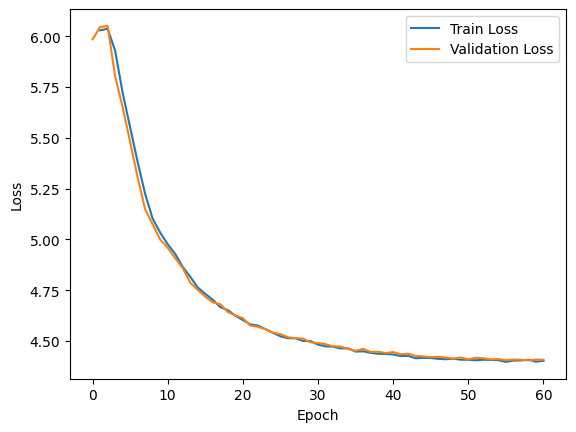

In [14]:
import matplotlib.pyplot as plt

# Plot losses
plt.plot(model.train_losses, label='Train Loss')
plt.plot(model.val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()